# Evaluating neural network performance

In this module, we show how we can evaluate a neural network.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import QuantLib as ql
import time

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import probplot
from IPython import display
from sklearn.metrics import r2_score

import HestonUtils
from HestonNN import Net

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [15, 10]

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU


We pull the `generateData` function from **Module 1-Data Generation** in order to create test sets to evaluate our neural networks on.

In [2]:
def generateData(M=1000, data_type='NARROW', SAVE_DATA=False):
    '''
    M: number of data points to generate
    data_type: either 'NARROW' or 'WIDE' depending on which sampling range we want to draw from
    SAVE_DATA: True if we want to save the data in ./data (useful if generating large-sized data), false otherwise
    '''
    # observed parameters: S, K, T, r, q
    Ss = np.random.uniform(low=0.5,high=1.5,size=M)
    Ks = np.array([1]*M)
    Ts = np.random.randint(low=1,high=365*2+1,size=M) / 365.
    rs = np.random.uniform(low=0,high=0.05,size=M)
    qs = np.random.uniform(low=0,high=0.05,size=M)
    
    # observe moneyness: S/K
    observed_params = np.array([Ss/Ks, Ts, rs, qs]).T
    
    # Heston parameters: v_0, kappa, v_bar, sigma, rho
    heston_params = np.zeros((M,5))
    if 'NARROW' in data_type:
        bounds = ((0, 0.5),
                  (0, 3),
                  (0, 0.5),
                  (0, 1),
                  (-0.9, 0))
    else: # WIDE
        bounds = ((0, 1),
                  (0, 10),
                  (0, 1),
                  (0, 2),
                  (-1, 0))
    bounds = np.array(bounds)
    
    for m in range(M):
        heston_params[m] = np.random.uniform(low=bounds[:,0], high=bounds[:,1])
        
        # Feller condition must be satisifed
        while 2*heston_params[m,1]*heston_params[m,2] <= heston_params[m,3]**2:
            heston_params[m] = np.random.uniform(low=bounds[:,0], high=bounds[:,1])
    
    # nn_parameters is what we will feed into our neural network
    nn_parameters = np.hstack((observed_params[:,:2], heston_params, observed_params[:,2:]))
    # ql_parameters is equivalent to nn_parameters but in a form that QuantLib takes
    ql_parameters = HestonUtils.convertNNtoQLparams(nn_parameters)
    
    h_prices = np.array([HestonUtils.QuantlibHestonPrice(*ql_parameters[i]) for i in range(M)])
    
    if SAVE_DATA:
        np.save(f'data/Heston_params_{data_type}.npy', nn_parameters)
        np.save(f'data/Heston_target_{data_type}.npy', h_prices)
        
    return nn_parameters, h_prices

We now create an analytic module to evaluate the performance of a given neural network.

In [3]:
class AnalyticModule:
    def __init__(self, net):
        self.net = net
        self.data_type = None
        self.evaluation_set = None
        self.y_trues = None
        self.y_preds = None
        self.outliers = None
        self.bounds = None
        self.PARAMS = ['Moneyness', 'Maturity (yrs)', 'v_0', 'kappa', 'v_bar', 'sigma', 'rho', 'rf rate', 'dv rate']
        self.EPS = 1e-8
    
    # attach an evaluation set to the neural network
    def attachEvaluationSet(self, data_type='NARROW_test', STORED_DATA=True, M=100000):
        '''
        data_type: either 'NARROW' or 'WIDE' depending on which kind of dataset we want to evaluate the given net on
        STORE_DATA: True if we want to use stored data, False if we want to generate entirely new data
        M: number of data points we want to create (if STORE_DATA=False)
        '''
        time_start = time.time()
        self.data_type=data_type
        if STORED_DATA:
            self.evaluation_set = np.load(f'data/Heston_params_{self.data_type}.npy')
            self.y_trues = np.load(f'data/Heston_target_{self.data_type}.npy')
        else: # generate a new dataset
            self.evaluation_set, self.y_trues = generateData(M=M, data_type=self.data_type)
            print(time.time() - time_start)

        if 'NARROW' in self.data_type:
            self.bounds = ((0.5,1.5), (0.01,2), (0,0.5), (0,3), (0,0.5), (0,1), (-0.9,0), (0,0.05), (0,0.05))
        else: # wide
            self.bounds = ((0.5,1.5), (0.01,2), (0,1), (0,10), (0,1), (0,2), (-1,0), (0,0.05), (0,0.05))
        nn_parameters = torch.Tensor(self.evaluation_set).float().to(device)
        self.y_preds = self.net(nn_parameters).to('cpu').detach().numpy().flatten()
        return
        
    # calculate a number of general error metrics
    def analyzeErrors(self):
        errors = self.y_preds - self.y_trues
        MAEloss = np.mean(np.abs(errors))
        MSEloss = np.mean(np.square(errors))

        print('Mean absolute error: ', MAEloss)
        print('Mean squared error: ', MSEloss)
        print('Largest absolute error: ', max(abs(errors)))

        # outliers can be adjusted as necessary; it is not used in any of the functions below but can be useful to report
        outliers = (abs(errors) > 10*MAEloss).flatten()
        self.outliers = outliers

        ### PLOTS  
        # plot predictions against true prices
        f = plt.figure(facecolor='w')
        ax2 = f.add_subplot(111)
        ax2.scatter(self.y_trues, self.y_preds, s=0.2)
        ax2.set_title('Accuracy of $\mathcal{NN}_{wide}$ on narrow testing set')
        ax2.set_xlabel('true option price')
        ax2.set_ylabel('predicted option price')
        abs_error = np.max(abs(errors))
        ax2.text(plt.xlim()[0]+0.1*plt.xlim()[1],0.9*plt.ylim()[1], f'$R^2: {r2_score(self.y_trues, self.y_preds)}$')
        plt.show(f)
        
        # plot histogram of errors, in a range of -2.5e-4 to 2.5e-4 (errors outside the range are reported as clipped)
        f = plt.figure(facecolor='w')
        ax3 = f.add_subplot(111)
        ax3.hist(errors[abs(errors) < 0.00025], bins=100)
        ax3.set_ylabel('count')
        ax3.set_title('distribution of errors for $\mathcal{NN}_{narrow}$')
        ax3.text(plt.xlim()[0]+0.1*plt.xlim()[1],0.9*plt.ylim()[1], f'clipped: {len(errors[abs(errors) >= 0.0025])}')
        plt.show(f)
        
        # plot a Q-Q plot of errors, to check normality
        res = probplot(errors)
        plt.scatter(res[0][0],res[0][1], s=1)
        plt.plot(plt.xlim(),res[1][0]*np.array(plt.xlim())+res[1][1])
        plt.xlabel('theoretical quantiles')
        plt.ylabel('ordered errors')
        plt.title('Q-Q plot of errors')
        plt.show()
        
        return errors
        
    # a more in-depth look at the errors at a single point
    def analyzePoint(self, index=0):
        '''
        index: index of point in dataset organized from lowest to highest MSE (e.g. -1 is the worst performing point)
        '''
        errors = abs(self.y_preds - self.y_trues)
        sorted_errors = errors[np.argsort(errors)]
        sorted_parameters = self.evaluation_set[np.argsort(errors)]
        
        fig = plt.figure(figsize=(15,20))
        
        desired = sorted_parameters[index]
        for i in range(len(desired)):
            nn_parameters = np.tile(desired, 100).reshape(-1,9)
            dependent_var = np.linspace(self.bounds[i][0]+self.EPS, stop=self.bounds[i][1]-self.EPS, num=100)
            nn_parameters[:,i] = dependent_var
            ql_parameters = HestonUtils.convertNNtoQLparams(nn_parameters)
            nn_parameters = torch.Tensor(nn_parameters).float().to(device)
            y_trues = np.array([HestonUtils.QuantlibHestonPrice(*ql_parameters[i]) for i in range(100)])
            y_preds = self.net(nn_parameters).to('cpu').detach().numpy().flatten()
            plt.subplot(4,3,i+1)
            plt.plot(dependent_var, y_trues, c='k')
            plt.plot(dependent_var, y_preds, c='orange')
            plt.title(f'{self.PARAMS[i]}')
            plt.axvline(x=desired[i], ls=':', lw=2)
        plt.suptitle(f'sample {index}')
        plt.show()

Here we initialize an analytic object, and then attach an evaluation set using stored data, and then we run the error analysis. This particular example tests $\mathcal{NN}_{narrow}$ on a narrow test set.

Mean absolute error:  2.2710268148757235e-05
Mean squared error:  1.4703013324267255e-09
Largest absolute error:  0.0022799841720285946


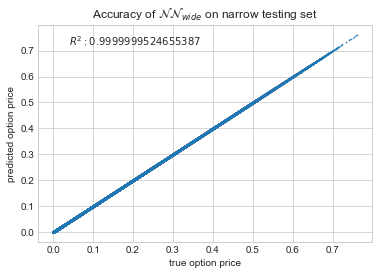

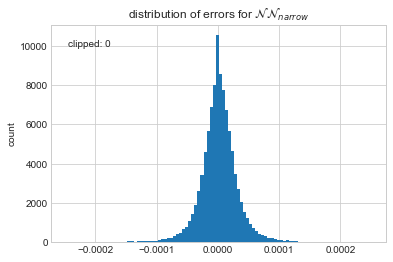

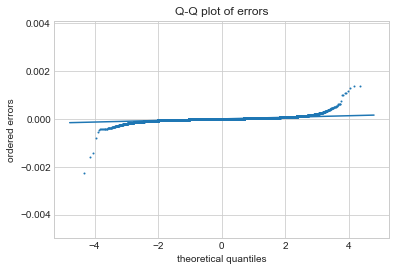

In [5]:
narrow_net = torch.load('models/run_133')

narrow = AnalyticModule(narrow_net)

narrow.attachEvaluationSet(data_type='NARROW_test', STORED_DATA=True)
errors_narrow = narrow.analyzeErrors()

We can also check the performance at a specific point. Here we pick a generic point in the dataset:

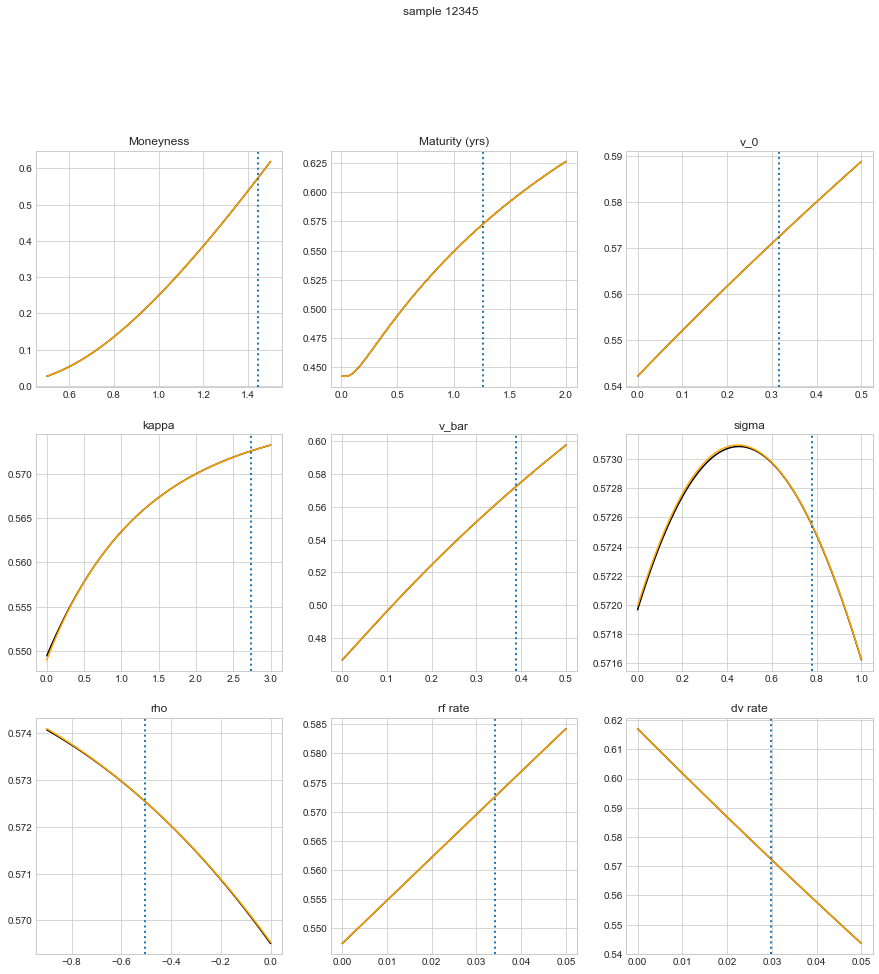

In [7]:
narrow.analyzePoint(12345)

The black line is the true price, and the orange line is the predicted price. The dotted blue line is the value of the parameter at the given data point. We can also look at the worst performing point and see what the plots look like:

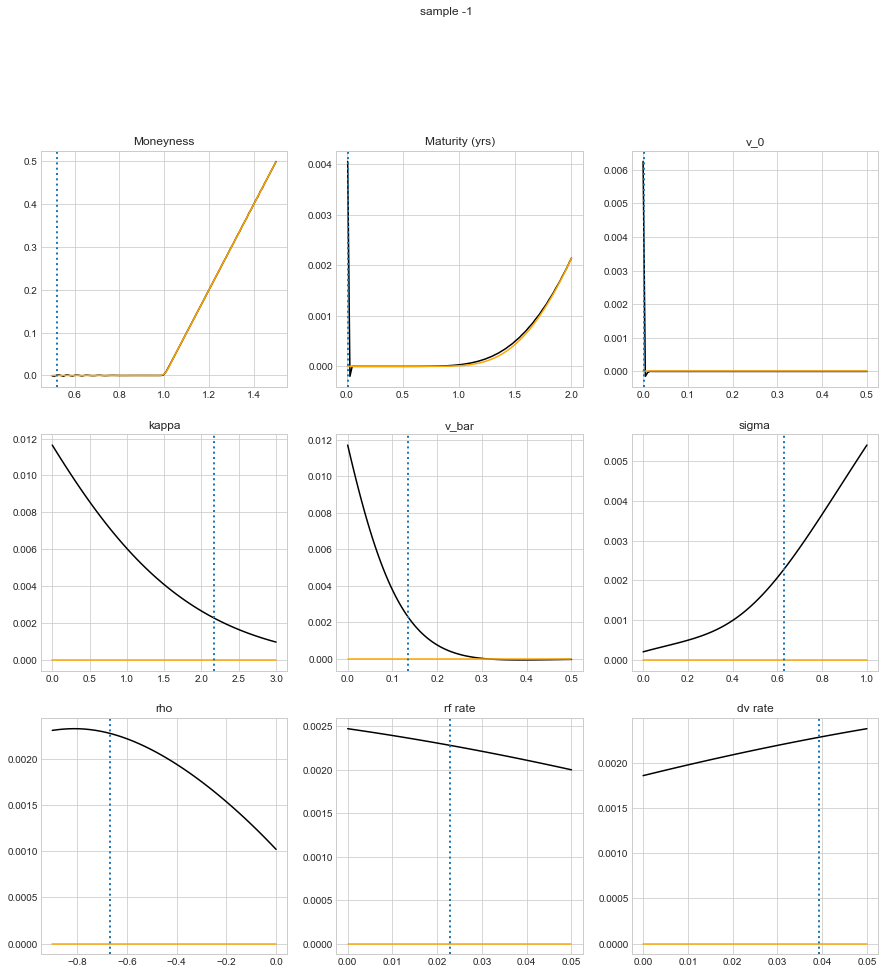

In [8]:
narrow.analyzePoint(-1)

Unsurprisingly, at our worst performing point we can see that our neural network does not do a good job of fitting.